## Deps

In [1]:
import os
import sys
import torch
import av
import numpy as np
import pandas as pd
from PIL import Image
import moviepy
import moviepy.editor as mp
import time
from IPython.display import clear_output
from tqdm import tqdm
import tempfile
import matplotlib.pyplot as plt
import seaborn as sns

from ultralytics import YOLO

In [3]:
def format_time(seconds):
    hours = int(seconds // 3600)
    minutes = int((seconds % 3600) // 60)
    seconds = int(seconds % 60)
    return f"{hours:02}:{minutes:02}:{seconds:02}"

def read_video_pyav(container, indices):
    '''
    Decode the video with PyAV decoder.
    Args:
        container (`av.container.input.InputContainer`): PyAV container.
        indices (`List[int]`): List of frame indices to decode.
    Returns:
        result (np.ndarray): np array of decoded frames of shape (num_frames, height, width, 3).
    '''
    frames = []
    container.seek(0)
    start_index = indices[0]
    end_index = indices[-1]
    for i, frame in enumerate(container.decode(video=0)):
        if i > end_index:
            break
        if i >= start_index and i in indices:
            frames.append(frame)
    return np.stack([x.to_ndarray(format="rgb24") for x in frames])


def sample_frame_indices(clip_len, frame_sample_rate, seg_len):
    '''
    Sample a given number of frame indices from the video.
    Args:
        clip_len (`int`): Total number of frames to sample.
        frame_sample_rate (`int`): Sample every n-th frame.
        seg_len (`int`): Maximum allowed index of sample's last frame.
    Returns:
        indices (`List[int]`): List of sampled frame indices
    '''
    converted_len = int(clip_len * frame_sample_rate)
    end_idx = np.random.randint(converted_len, seg_len)
    # start_idx = end_idx - converted_len
    # start_idx = clip_len
    start_idx = 0
    indices = np.linspace(start_idx, end_idx, num=clip_len)
    indices = np.clip(indices, start_idx, end_idx - 1).astype(np.int64)
    return indices

# Function to sample uniformly with specified values
def uniform_sample_with_values(df, sample_size, groupby_cols, filter_values = None):
    copy = df.copy(deep=True)
    # Filter dataframe based on specified values for each column
    if filter_values is not None:
        for col, values in filter_values.items():
            copy = copy[copy[col].isin(values)]
    
    # Calculate the number of rows to sample per group
    num_groups = copy.groupby(groupby_cols).ngroups
    sample_per_group = max(sample_size // num_groups, 1)
    
    # Sample uniformly within each group
    sampled_df = copy.groupby(groupby_cols, group_keys=False).apply(lambda x: x.sample(min(len(x), sample_per_group)))
    
    # If we sampled less than the desired sample_size due to group sizes, sample more from the remaining dataframe
    if len(sampled_df) < sample_size:
        remaining_sample_size = sample_size - len(sampled_df)
        remaining_df = copy[~copy.index.isin(sampled_df.index)]
        additional_samples = remaining_df.sample(min(len(remaining_df), remaining_sample_size))
        sampled_df = pd.concat([sampled_df, additional_samples])
    
    return sampled_df, copy[~copy.index.isin(sampled_df.index)]

def extract_images(aptms, mp4_files, root_dir, num_images = 10, delta = 20, step = 0):
    
    size = len(aptms)
    records = []
    for idx in tqdm(range(size), desc="Processing items"):
        one_row = aptms.iloc[idx]
        target = one_row['State']
            
        cond = (
            (mp4_files["start_date"] == str(one_row.datetime.date()))
            & (mp4_files["start_time"] <= one_row.datetime)
            & (mp4_files["end_time"] > one_row.datetime)
            & (mp4_files["station"] == one_row.parc)
        )

        # print(mp4_files[cond].shape)
        
        if mp4_files[cond].shape[0] == 0:
            continue

        dir_path = root_dir + "/" + target
        if not os.path.exists(dir_path):
            os.makedirs(dir_path)
            
        for index, file in mp4_files[cond].iterrows():
            zero = (one_row["datetime"] - file["start_time"]).total_seconds()
            if zero - delta > 0:
                break
    
        video = mp.VideoFileClip(file["path"])
        start_at = max(zero - delta, 0)
        end_at = max(zero - step, 0)
        
        if end_at <= start_at or (end_at - start_at) <= 1:
            continue
            
        clip = video.subclip(start_at, end_at)

        # Save a sample 16 frames of video a image and save them
        # Convert the clip to a PyAV container
        with tempfile.NamedTemporaryFile(suffix='.mp4') as tmpfile:
            clip.write_videofile(tmpfile.name, logger= None)
            container = av.open(tmpfile.name)

            video_stream = container.streams.video[0]

            # Get the duration in time base units
            duration_in_units = video_stream.duration
            
            # Get the time base
            time_base = video_stream.time_base
            
            # Calculate the duration in seconds
            duration_in_seconds = duration_in_units * time_base

            # Sample 16 frames
            fps = int(container.streams.video[0].average_rate)
            seg_len = int(duration_in_seconds) * fps
            indices = sample_frame_indices(clip_len=num_images, frame_sample_rate=6, seg_len=seg_len)
            video_frames = read_video_pyav(container, indices)
            
            # Save frames as images
            for frame_idx, frame in enumerate(video_frames):
                img = Image.fromarray(frame)
                filename = f"image_{idx}_{frame_idx}_{one_row['calfNumber']}_{one_row['parc']}_{one_row['datetime']}_{target}.png"
                img_save_path = os.path.join(dir_path, filename)
                img.save(img_save_path)

                records.append({
                    "image": filename,
                    "path": img_save_path,
                    "label": target,
                    "calf": one_row["calfNumber"],
                    "station": one_row["parc"],
                    "before": one_row["datetime"],
                    "from": file["path"]
                })
            
    clear_output()
    return pd.DataFrame(records)

def extract_from_videos(aptms, mp4_files, root_dir, frame_sample_rate = 4, num_images = 16, bbox_conf = .8, delta = 20, step = 0, model = None):
    type2dir = {0: "Face", 1: "Rigth", 2: "Left" }
    size = len(aptms)
    records = []
    for idx in tqdm(range(size), desc="Processing items"):
        one_row = aptms.iloc[idx]
        target = one_row['State']
            
        cond = (
            (mp4_files["start_date"] == str(one_row.datetime.date()))
            & (mp4_files["start_time"] <= one_row.datetime)
            & (mp4_files["end_time"] > one_row.datetime)
            & (mp4_files["station"] == one_row.parc)
        )

        if mp4_files[cond].shape[0] == 0:
            continue

        dir_path = root_dir + "/" + target
        if not os.path.exists(dir_path):
            os.makedirs(dir_path)

        for index, file in mp4_files[cond].iterrows():
            zero = (one_row["datetime"] - file["start_time"]).total_seconds()
            if zero - delta > 0:
                break
    
        video = mp.VideoFileClip(file["path"])
        start_at = max(zero - delta, 0)
        end_at = max(zero - step, 0)
        
        if end_at <= start_at or (end_at - start_at) <= 1:
            continue
            
        clip = video.subclip(start_at, end_at)
        nfaces = 0
        
        with tempfile.NamedTemporaryFile(suffix='.mp4') as tmpfile:
            clip.write_videofile(tmpfile.name, logger= None)
            container = av.open(tmpfile.name)

            video_stream = container.streams.video[0]

            # Get the duration in time base units
            duration_in_units = video_stream.duration
            
            # Get the time base
            time_base = video_stream.time_base
            
            # Calculate the duration in seconds
            duration_in_seconds = duration_in_units * time_base

            # Sample 16 frames
            fps = int(container.streams.video[0].average_rate)
            seg_len = int(duration_in_seconds) * fps
            sample_rate = min(int(seg_len / num_images) - 1, frame_sample_rate)
            indices = sample_frame_indices(clip_len=num_images, frame_sample_rate=sample_rate, seg_len=seg_len)
            video_frames = read_video_pyav(container, indices)
            video_images = [Image.fromarray(frame) for frame in video_frames]
            results = model.predict(video_images, save=False, imgsz=640, conf=bbox_conf, max_det=1, show=False)

            for frame_idx, r in enumerate(results):
                if r.boxes.shape[0] == 0:
                    continue
                else:
                    conf = r.boxes.cpu().numpy().conf[0]
                    dir_id = r.boxes.cpu().numpy().cls[0]
                    x1, y1, width, height =  r.boxes.cpu().numpy().xywh[0]

                img = video_images[frame_idx]
                filename = f"image_{idx}_{frame_idx}_{one_row['calfNumber']}_{one_row['parc']}_{one_row['datetime']}_{target}.png"
                img_save_path = os.path.join(dir_path, filename)
                img.save(img_save_path)

                records.append({
                    "image": filename,
                    "path": img_save_path,
                    "label": target,
                    "calf": one_row["calfNumber"],
                    "station": one_row["parc"],
                    "before": one_row["datetime"],
                    "from": file["path"],
                    "conf": conf, 
                    "type": type2dir[dir_id],
                    "box_x": x1,
                    "box_y": y1,
                    "box_width": width,
                    "box_height": height
                })
    
    clear_output()
    return pd.DataFrame(records)

## Tests

In [2]:
csv_path = "video_extracted_metadat.csv"
df = pd.read_csv(csv_path, index_col=False)
labels = df.label.unique()

label2id = {l:i for i, l in enumerate(labels)}
id2label = {i:l for i, l in enumerate(labels)}
df['target'] = df.apply(lambda row: label2id[row['label']], axis=1)

In [4]:
base_dir = "/data/konrad/"
video_path = base_dir + "video_classification/temp_videos/Pneumonie/clip_2_6786_2_2022-02-25 17:44:54_Pneumonie.mp4"

In [8]:
container = av.open(video_path)

# sample 16 frames
indices = sample_frame_indices(clip_len=16, frame_sample_rate=1, seg_len=container.streams.video[0].frames)
video = read_video_pyav(container, indices)

# Save each frame as an image
for idx, frame in enumerate(video):
    img = Image.fromarray(frame)
    img.save(f'temp_images/frame_{idx}.png')

In [28]:
int(container.streams.video[0].average_rate)

25

In [24]:
# Get the video stream
video_stream = container.streams.video[0]

# Get the duration in time base units
duration_in_units = video_stream.duration

# Get the time base
time_base = video_stream.time_base

# Calculate the duration in seconds
duration_in_seconds = duration_in_units * time_base

print(f"Duration in time base units: {duration_in_units}")
print(f"Time base: {time_base}")
print(f"Duration in seconds: {duration_in_seconds}")

Duration in time base units: 256000
Time base: 1/12800
Duration in seconds: 20


In [50]:
aptm_with_state = pd.read_csv('aptm_with_state.csv', index_col=False)
spaced_aptm_with_state = pd.read_csv('spaced_aptm_with_state.csv', index_col=False)
mp4_files = pd.read_csv('mp4_files.csv', index_col=False)

spaced_aptm_with_state["datetime"] = pd.to_datetime(spaced_aptm_with_state["datetime"])
mp4_files["start_time"] = pd.to_datetime(mp4_files["start_time"])
mp4_files["end_time"] = pd.to_datetime(mp4_files["end_time"])

In [13]:
frame_sample_rate = 4
clip_len = 16
seg_len = 500

converted_len = int(clip_len * frame_sample_rate)
end_idx = np.random.randint(converted_len, seg_len)
start_idx = end_idx - converted_len
indices = np.linspace(start_idx, end_idx, num=clip_len)
# indices = np.clip(indices, start_idx, end_idx - 1).astype(np.int64)
indices

array([159.        , 163.26666667, 167.53333333, 171.8       ,
       176.06666667, 180.33333333, 184.6       , 188.86666667,
       193.13333333, 197.4       , 201.66666667, 205.93333333,
       210.2       , 214.46666667, 218.73333333, 223.        ])

In [14]:
indices = np.clip(indices, start_idx, end_idx - 1).astype(np.int64)
indices

array([159, 163, 167, 171, 176, 180, 184, 188, 193, 197, 201, 205, 210,
       214, 218, 222])

In [15]:
len(indices)

16

In [16]:
end_idx, converted_len, start_idx

(223, 64, 159)

In [18]:
indices = np.linspace(0, 500, num=clip_len)
indices = np.clip(indices, 0, 500 - 1).astype(np.int64)
indices

array([  0,  33,  66, 100, 133, 166, 200, 233, 266, 300, 333, 366, 400,
       433, 466, 499])

In [ ]:
aptm_with_state = pd.read_csv('aptm_with_state.csv', index_col=False)
spaced_aptm_with_state = pd.read_csv('spaced_aptm_with_state.csv', index_col=False)
mp4_files = pd.read_csv('mp4_files.csv', index_col=False)

spaced_aptm_with_state["datetime"] = pd.to_datetime(spaced_aptm_with_state["datetime"])
mp4_files["start_time"] = pd.to_datetime(mp4_files["start_time"])
mp4_files["end_time"] = pd.to_datetime(mp4_files["end_time"])

In [67]:
str(one_row.datetime.date())

'2022-04-04'

## Extractions

In [4]:
aptm_with_state = pd.read_csv('aptm_with_state.csv', index_col=False)
spaced_aptm_with_state = pd.read_csv('spaced_aptm_with_state.csv', index_col=False)
mp4_files = pd.read_csv('mp4_files.csv', index_col=False)

spaced_aptm_with_state["datetime"] = pd.to_datetime(spaced_aptm_with_state["datetime"])
mp4_files["start_time"] = pd.to_datetime(mp4_files["start_time"])
mp4_files["end_time"] = pd.to_datetime(mp4_files["end_time"])

In [6]:
# Specify the columns to group by and the sample size
groupby_cols = ['calfNumber', 'parc', 'State']
sample_size = 2000

# selected_calf = spaced_aptm_with_state["calfNumber"].value_counts()[spaced_aptm_with_state["calfNumber"].value_counts() > 150].keys()
filter_values = {
    # 'calfNumber': selected_calf,  # Specify the values you want to include
    # 'parc': [1, 2, 10],
    'State': ['Diarrhé', 'Pneumonie', 'Healthy']
}

# Get the uniformly sampled dataframe
# sampled_df = uniform_sample(aptm_with_state, sample_size, groupby_cols)
aptm_sampled, aptm_rest = uniform_sample_with_values(spaced_aptm_with_state, sample_size, groupby_cols, filter_values = filter_values)
aptm_sampled = aptm_sampled.sample(frac=1).reset_index(drop=True)

# Ignoring balancing or sampling of dataset
aptm_sampled = spaced_aptm_with_state

In [6]:
one_row = aptm_sampled.iloc[330]
target = one_row['State']

cond = (
    (mp4_files["start_date"] == str(one_row.datetime.date()))
    & (mp4_files["start_time"] <= one_row.datetime)
    & (mp4_files["end_time"] > one_row.datetime)
    # & (mp4_files["start_hour"] == one_row.datetime.hour)
    # & (mp4_files["start_mn"] <= one_row.datetime.minute)
    & (mp4_files["station"] == one_row.parc)
    # (mp4_files["station"] == one_row.parc)
)
mp4_files[cond]

,station,start_at,end_at,path,start_time,end_time,start_date,start_hour,start_mn
374,1,2022-03-01T15:00:00,2022-03-01T16:00:00,/data/public/heureux_2022-02-16_2022-04-16/202...,2022-03-01 15:00:00,2022-03-01 16:00:00,2022-03-01,15,0


In [7]:
ROOT_DIR = "/data/konrad"
yolo = YOLO( ROOT_DIR + "/datasets/models/best-ft-detector.pt")

In [8]:
# Start time
start_time = time.time()

frame = 10
step = 2
frame_sample_rate = 4
num_images = 20
bbox_conf = .8
delta = frame + step
# root_dir = ROOT_DIR + "/datasets/images"
# root_dir = "temp_images"
root_dir = f"/data/data_calves/konrad/images_{num_images}_{frame}_{step}/"
# directory = root_dir + "train"


# records = extract_from_videos(aptm_sampled.iloc[:10], mp4_files, root_dir, delta = delta, step = step, frame_sample_rate = frame_sample_rate, num_images = num_images, model = yolo, bbox_conf = bbox_conf)
records = extract_from_videos(aptm_sampled, mp4_files, root_dir, delta = delta, step = step, frame_sample_rate = frame_sample_rate, num_images = num_images, model = yolo, bbox_conf = bbox_conf)

# End time
end_time = time.time()

# Calculate elapsed time
elapsed_time = end_time - start_time

formatted_time = format_time(elapsed_time)

# Display the elapsed time
print(f"Time of execution: {formatted_time} from {elapsed_time}")
records.to_csv('images_extracted_metadata.csv', index=False)

Time of execution: 03:04:50 from 11090.50006556511


In [9]:
records.shape, aptm_sampled.shape

((1317, 13), (3657, 7))

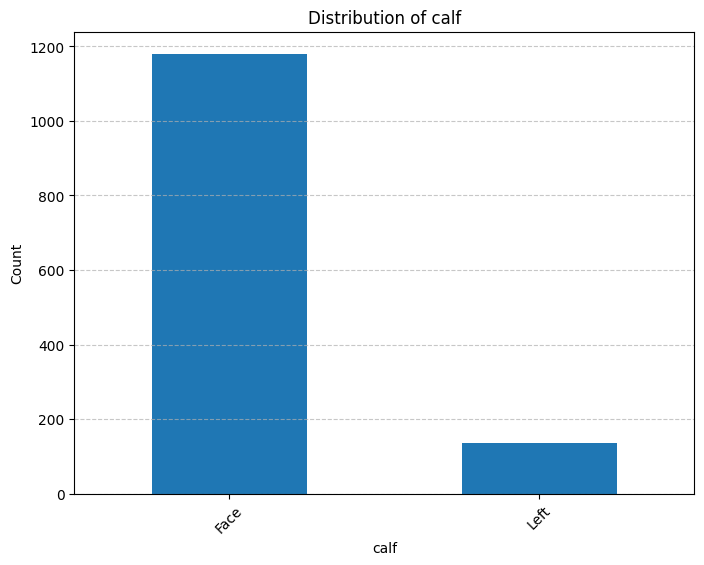

In [12]:
# Count the occurrences of each class
class_counts = records['type'].value_counts()

# Plot the distribution
plt.figure(figsize=(8, 6))
class_counts.plot(kind='bar')
plt.title('Distribution of calf')
plt.xlabel('calf')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

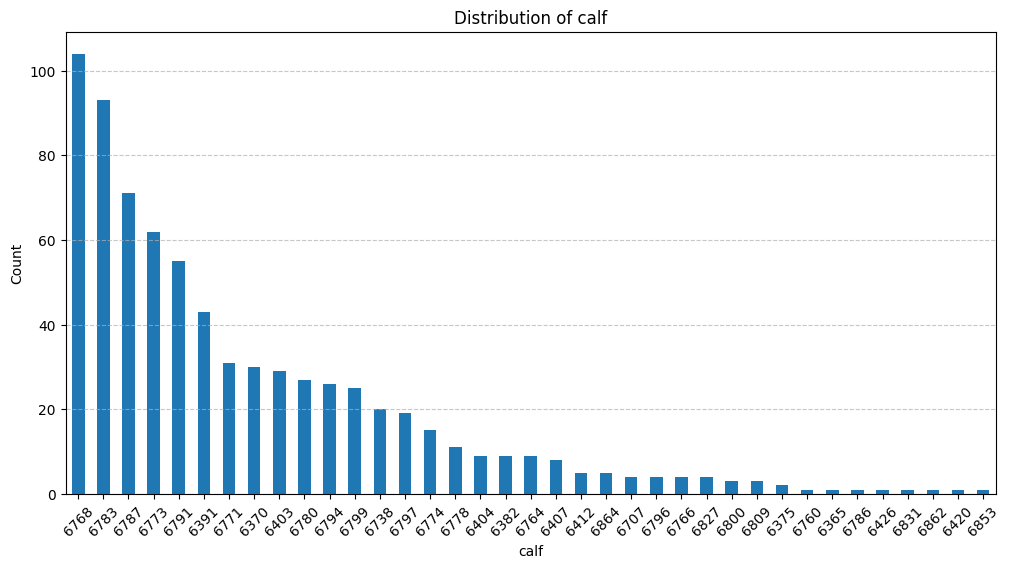

In [20]:
# Count the occurrences of each class
class_counts = records[~records["label"].isin(['Unknown', 'Diarrhé, Pneumonie'])]['calf'].value_counts()

# Plot the distribution
plt.figure(figsize=(12, 6))
class_counts.plot(kind='bar')
plt.title('Distribution of calf')
plt.xlabel('calf')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

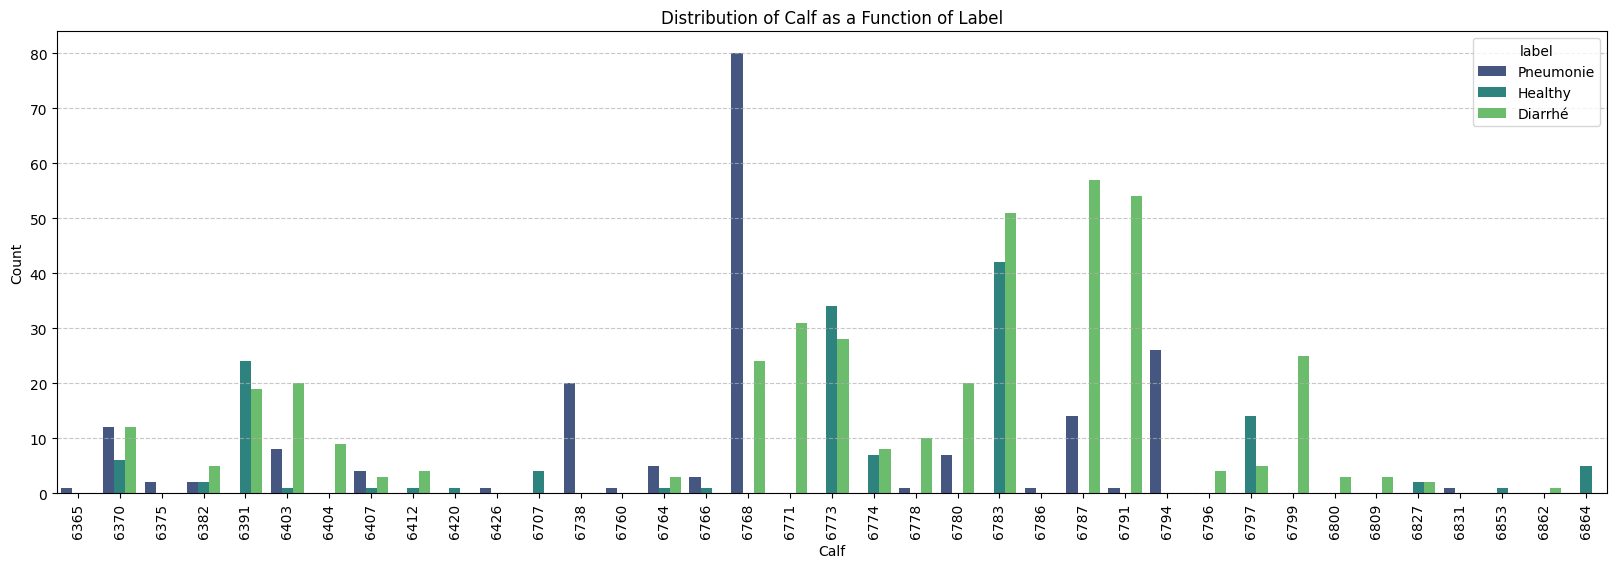

In [19]:
# Group by label and calf, and count the occurrences
sub_train_df = records[~records["label"].isin(['Unknown', 'Diarrhé, Pneumonie'])]
calf_distribution = sub_train_df.groupby(['label', 'calf']).size().reset_index(name='count').sort_values(by="count")

# Plotting the distribution as a barplot
plt.figure(figsize=(20, 6))
sns.barplot(x='calf', y='count', hue='label', data=calf_distribution, palette='viridis')
plt.title('Distribution of Calf as a Function of Label')
plt.xlabel('Calf')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()